In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import itertools
import warnings
from datetime import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
from pathlib import Path

#ignor the warnings
warnings.filterwarnings("ignore")

# Load the Excel file
data = pd.ExcelFile('../data/energy_forecasting.xlsx')

load_history = data.parse('load_history')
temp_history = data.parse('temperature_history')
holiday_list = data.parse('holiday_list')
submission_template = data.parse('submission_template')

#Handle missing values, if there are any
load_history = load_history.fillna(load_history.select_dtypes(include='number').mean(numeric_only=True))
temp_history = temp_history.fillna(temp_history.select_dtypes(include='number').mean(numeric_only=True))

# where to save reports
REPORT_DIR = Path("../reports")
FIG_DIR = REPORT_DIR / "figures"
REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# holders for per-zone metrics
zone_names, rmse_list, mae_list, r2_list = [], [], [], []

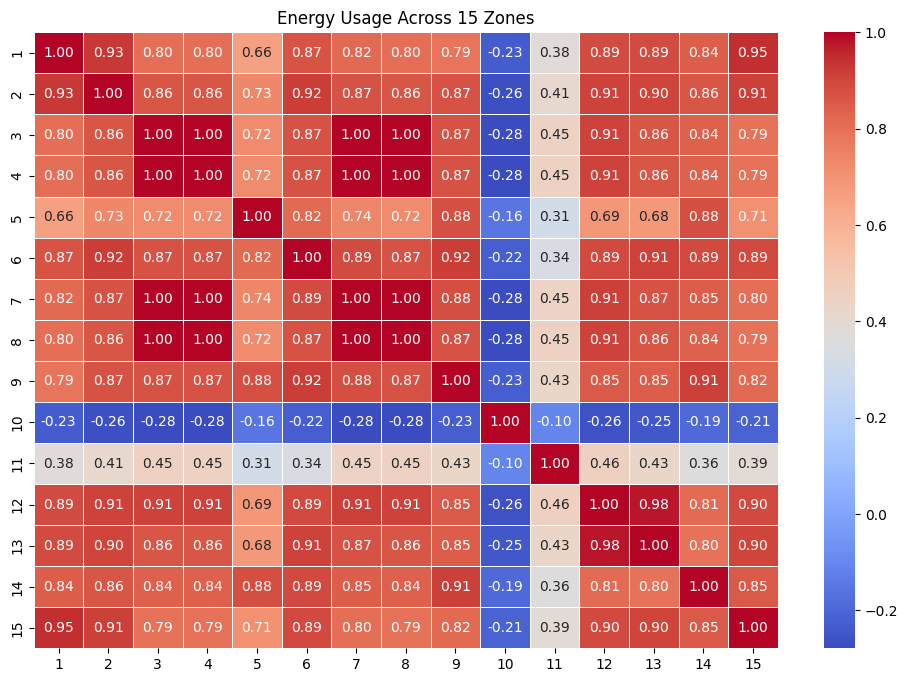

In [7]:
#EDA of load history

zone_columns = list(range(1, 16))

# Heatmap of all zones
plt.figure(figsize=(12, 8))
sns.heatmap(load_history[zone_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Energy Usage Across 15 Zones")
plt.show()

From the heatmap we observe:

- Zones **11** and **10** exhibit the least amount of energy used  
- Zones **3, 4, 7, and 8** exhibited high energy usage at the same time

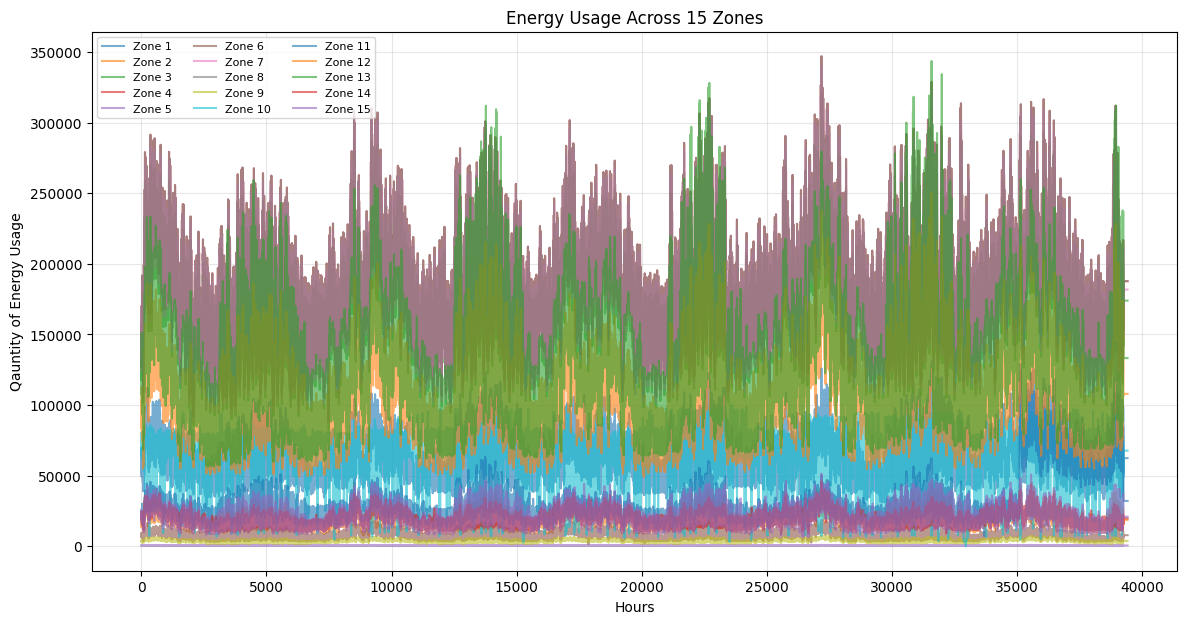

In [8]:
# Line Plot of energy usage per zone
plt.figure(figsize=(14, 7))
for zone in zone_columns:
    plt.plot(load_history.index, load_history[zone], label=f'Zone {zone}', alpha=0.6)
plt.xlabel("Hours")
plt.ylabel("Qauntity of Energy Usage")
plt.title("Energy Usage Across 15 Zones")
plt.legend(ncol=3, fontsize=8)
plt.grid(alpha=0.3)
plt.show()

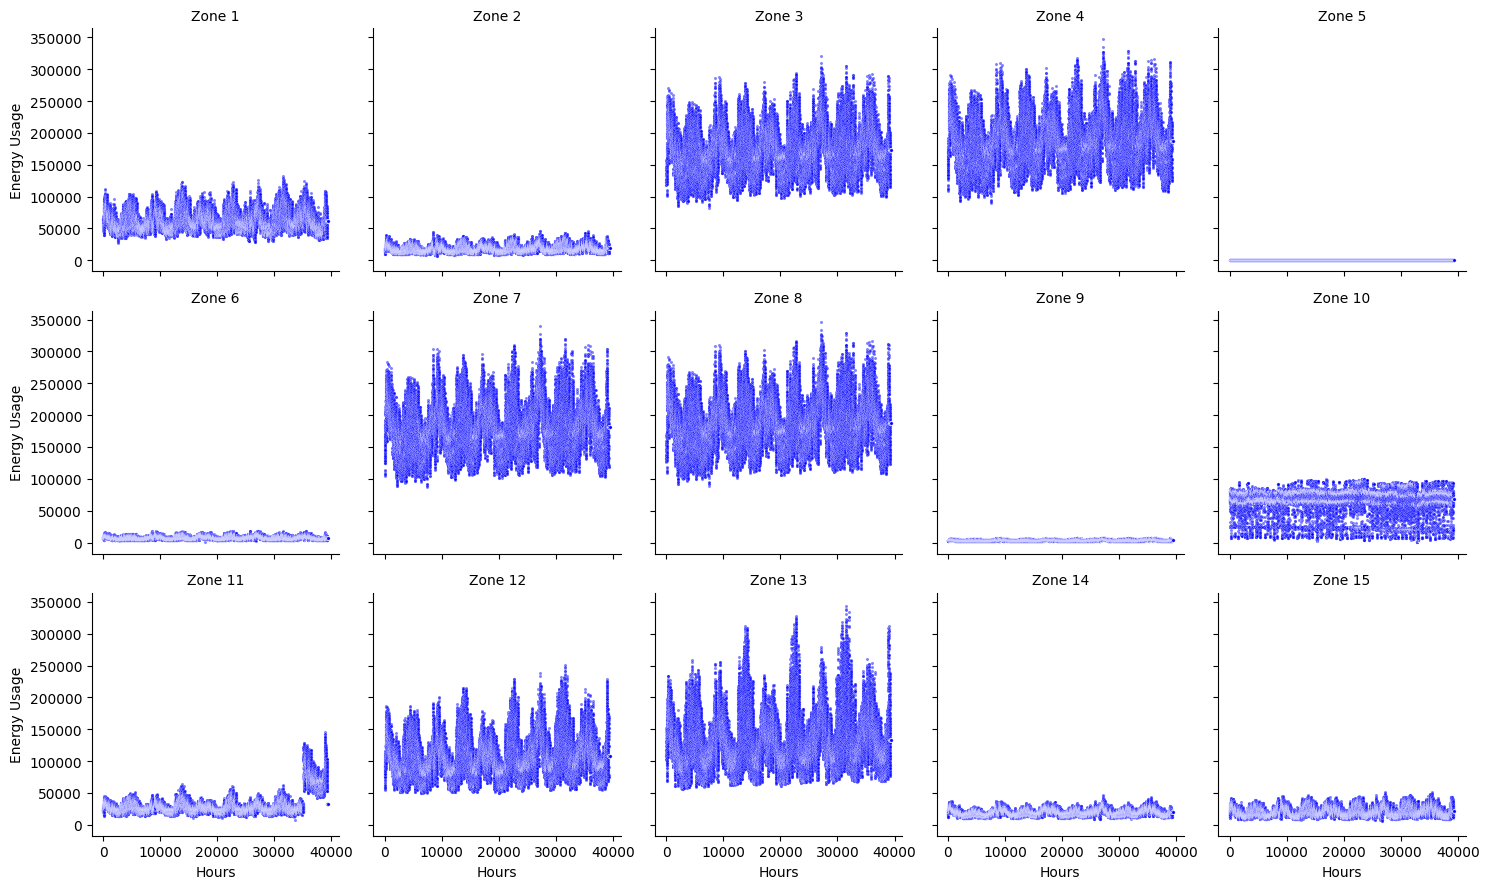

In [9]:
# Faceted Scatter Plot of zones into subplots
melted_data = load_history.melt(id_vars=['t'], value_vars=zone_columns, var_name="Zone", value_name="Energy Usage")
g = sns.FacetGrid(melted_data, col="Zone", col_wrap=5, height=3)
g.map(sns.scatterplot, "t", "Energy Usage", alpha=0.5, s=5, color='blue')
g.set_titles(col_template="Zone {col_name}")
g.set_axis_labels("Hours", "Energy Usage")
plt.show()

Using the lineplot and scatter plot we are able to observe which zones exhibit high energy usage

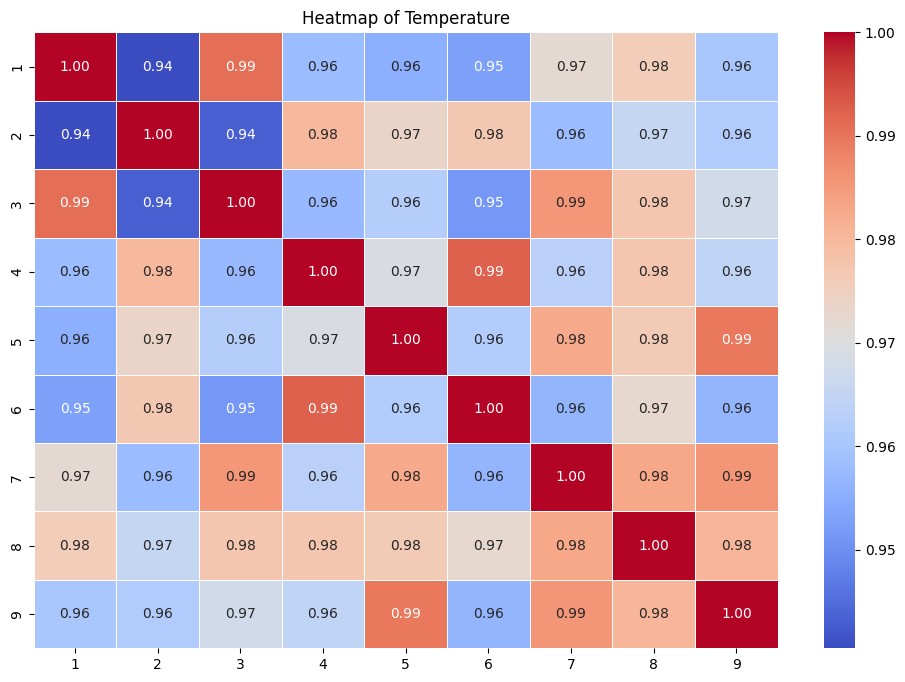

In [10]:
# EDA of temperature history

temp_columns = list(range(1, 10))

# Heatmap of temperature across available zones (9 instead of 15)
plt.figure(figsize=(12, 8))
sns.heatmap(temp_history[temp_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Temperature")
plt.show()

Based on the temperature heatmap we can conclude different locations have a similar temperature trend

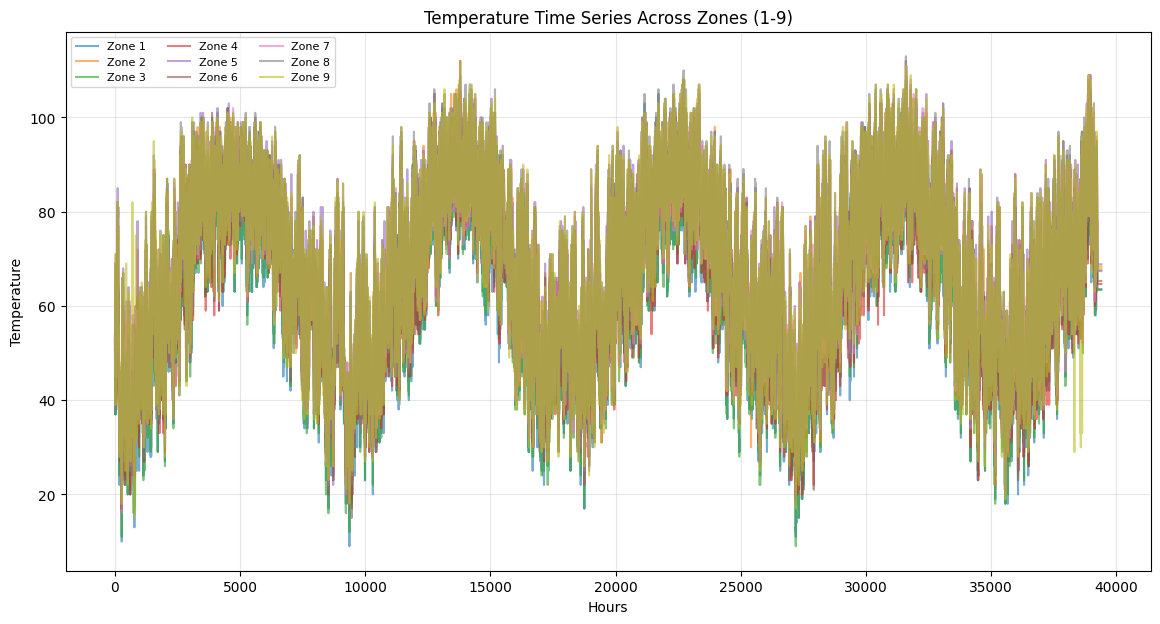

In [11]:
# Line Plot of temperature time series across zones
plt.figure(figsize=(14, 7))
for zone in temp_columns:
    plt.plot(temp_history.index, temp_history[zone], label=f'Zone {zone}', alpha=0.6)
plt.xlabel("Hours")
plt.ylabel("Temperature")
plt.title("Temperature Time Series Across Zones (1-9)")
plt.legend(ncol=3, fontsize=8)
plt.grid(alpha=0.3)
plt.show()

- We observe a flucuation in temperature based on seasons
- All of the zones exhibit similar trends with no major outliers

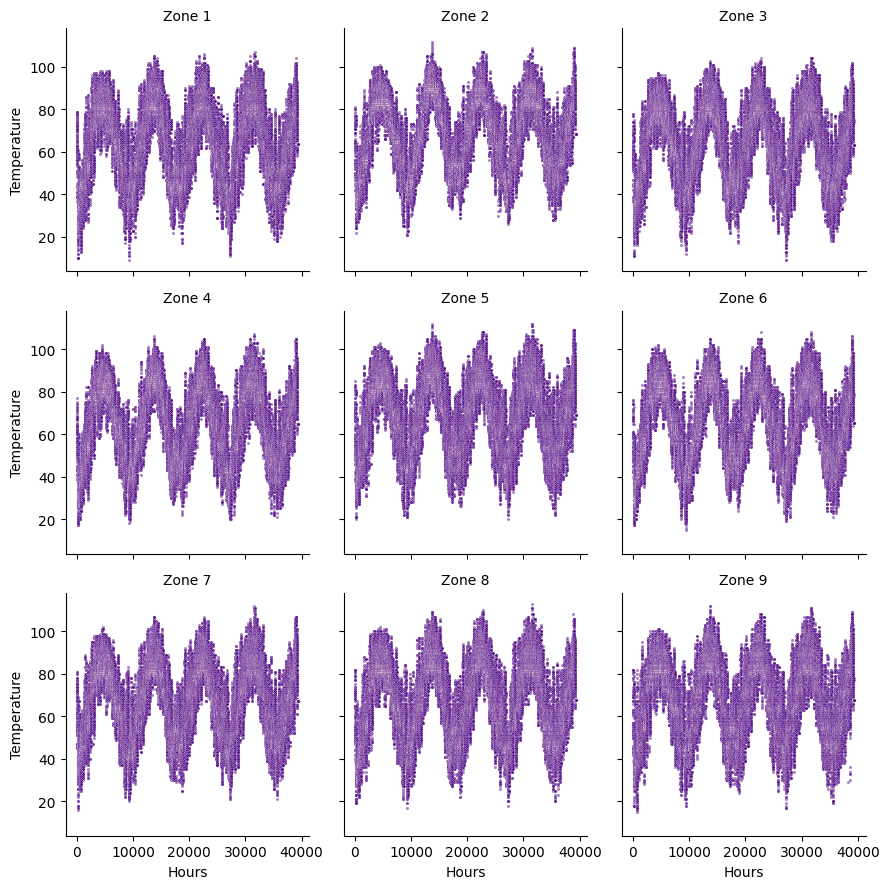

In [12]:
# Faceted Scatter Plot of Temperature
melted_temp = temp_history.melt(id_vars=['t'], value_vars=temp_columns, var_name="Zone", value_name="Temperature")
g = sns.FacetGrid(melted_temp, col="Zone", col_wrap=3, height=3)
g.map(sns.scatterplot, "t", "Temperature", alpha=0.5, s=5, color='#4B0082')
g.set_titles(col_template="Zone {col_name}")
g.set_axis_labels("Hours", "Temperature")
plt.show()

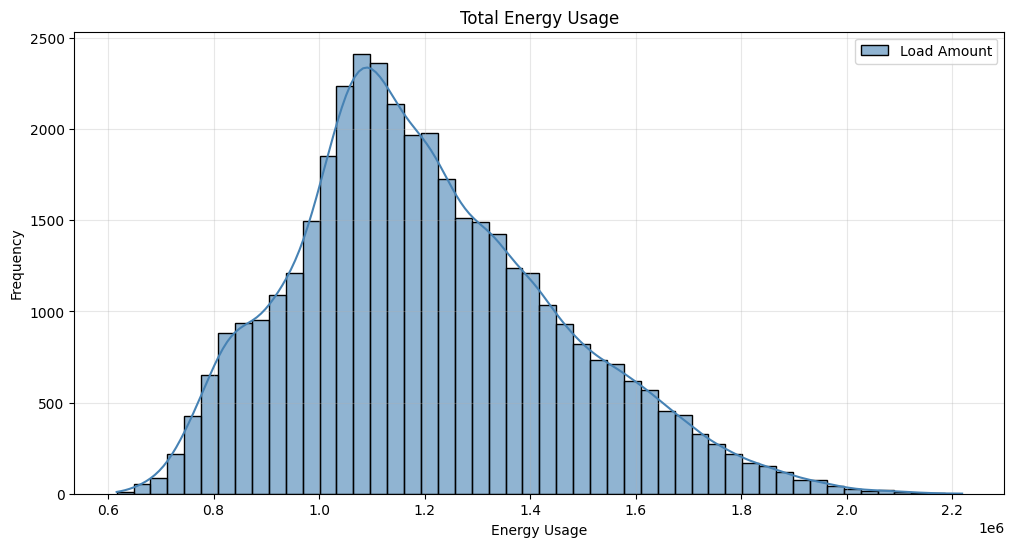

In [13]:
# Combined EDA of averages and distributions
# Histograms of Load Data
plt.figure(figsize=(12, 6))
sns.histplot(load_history['Total'], bins=50, kde=True, color='#4682B4', alpha=0.6, label="Load Amount")
plt.xlabel("Energy Usage")
plt.ylabel("Frequency")
plt.title("Total Energy Usage")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- From the histogram we observe a slight right skew 
- This means high load amounts are not frequent

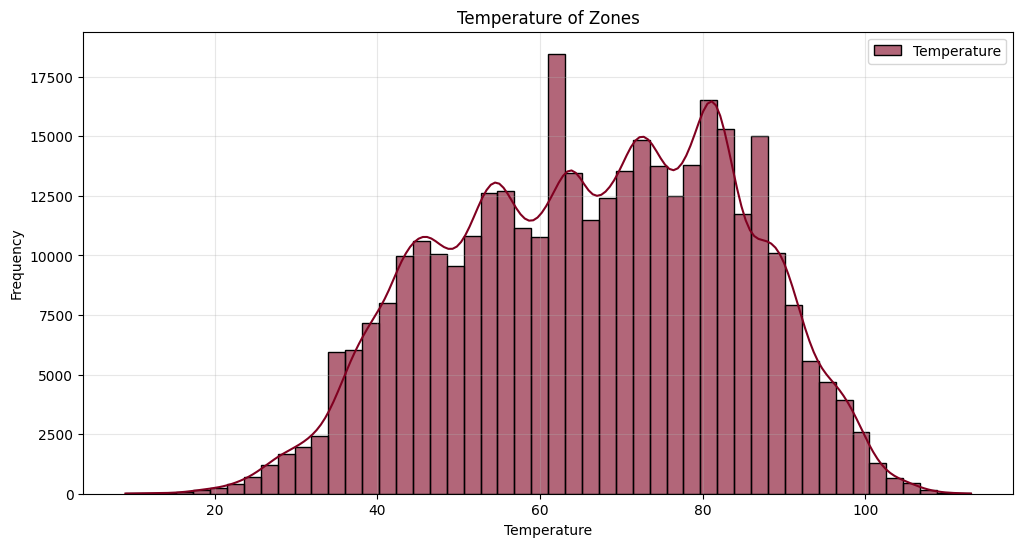

In [14]:
# Histogram of Temperature Data
plt.figure(figsize=(12, 6))
sns.histplot(temp_history[temp_columns].melt()['value'], bins=50, kde=True, color='#800020', alpha=0.6, label="Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature of Zones")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

This histogram represents the seasonal changes in temperature as the data displays many peaks

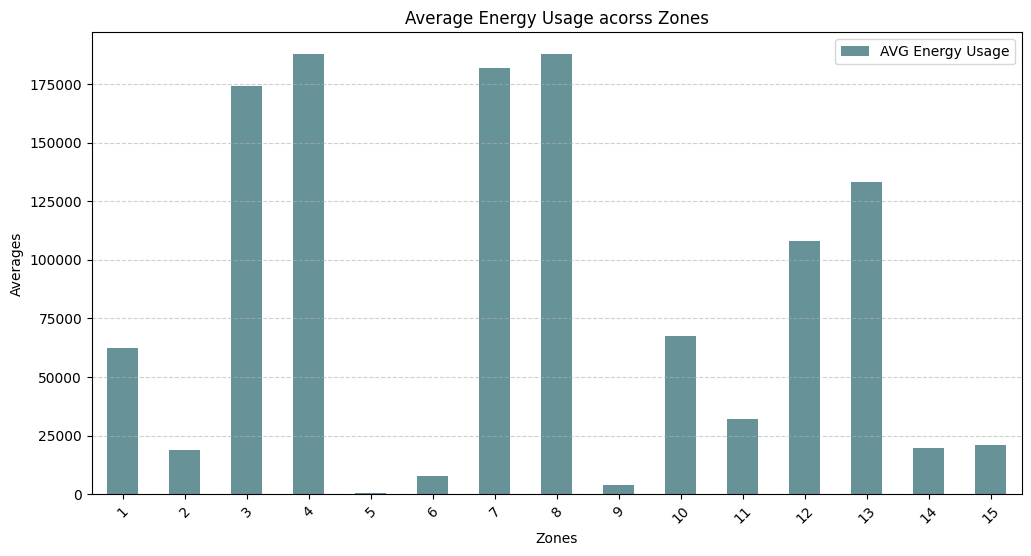

In [15]:
# Bar Plot of Average Energy Usage
plt.figure(figsize=(12, 6))
load_history[zone_columns].mean().plot(kind='bar', color='#004953', alpha=0.6, label="AVG Energy Usage")
plt.xlabel("Zones")
plt.ylabel("Averages")
plt.title("Average Energy Usage acorss Zones")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

- From the averages we observe high usage zones (3, 4, 7, 8)
- We also observe lower averages from zones (5, 6, 9)

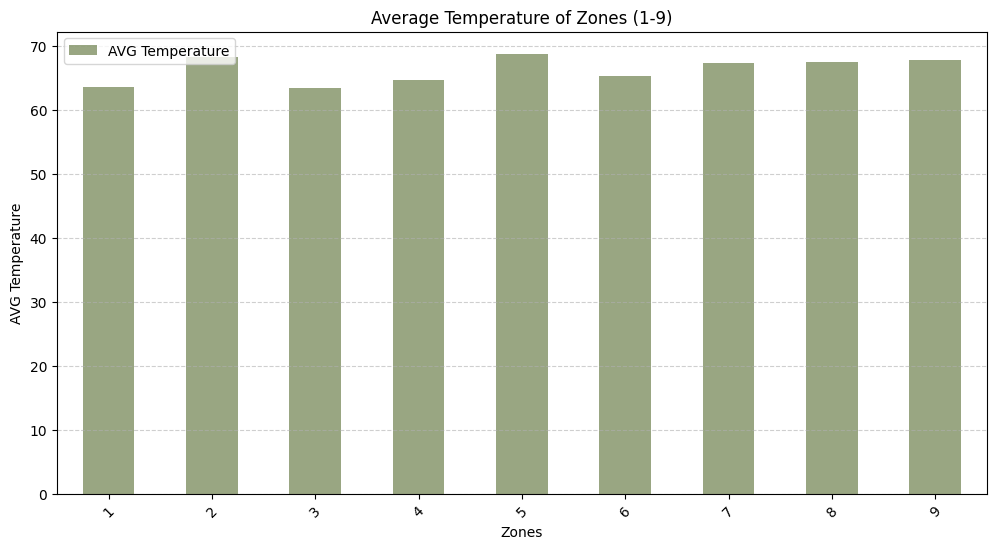

In [16]:
# Bar Plot of Average Temperatures
plt.figure(figsize=(12, 6))
temp_history[temp_columns].mean().plot(kind='bar', color='#556B2F', alpha=0.6, label="AVG Temperature")
plt.xlabel("Zones")
plt.ylabel("AVG Temperature")
plt.title("Average Temperature of Zones (1-9)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

- From the averages we don't observe much of a difference between zones
- This observation is an important indicator, suggesting other zone factors play a role in energy usage

In [17]:
# Create lag features for load data, we need these to merge two worksheet data
load_history['lag_1'] = load_history['Total'].shift(1)
load_history['lag_24'] = load_history['Total'].shift(24)

# Merge temperature and load history using common columns
merged_data = pd.merge(load_history, temp_history, on=['month', 'day', 'week', 'hour'])
print(merged_data)

# Define holiday dates for the year 2008
holiday_2008 = ['2008-01-01', '2008-01-21', '2008-02-18', '2008-05-26', '2008-07-04', '2008-09-01']
holiday_2008 = [datetime.strptime(date, '%Y-%m-%d') for date in holiday_2008]

# Add holiday feature
merged_data['is_holiday'] = merged_data.apply(
lambda row: 1 if datetime(row['year_x'], row['month'], row['day']) in holiday_2008 else 0, axis=1)

# We need these variaable p, d, q to use as parameters to take values between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
#We will these in the calculation of the best parameters

         t_x  year_x  month  day  ...        6_y        7_y        8_y        9_y
0          1    2004      1    1  ...  51.000000  53.000000  54.000000  52.000000
1          2    2004      1    1  ...  51.000000  52.000000  53.000000  53.000000
2          3    2004      1    1  ...  49.000000  51.000000  50.000000  51.000000
3          4    2004      1    1  ...  48.000000  47.000000  49.000000  43.000000
4          5    2004      1    1  ...  49.000000  47.000000  44.000000  39.000000
...      ...     ...    ...  ...  ...        ...        ...        ...        ...
39403  39404    2008      6   29  ...  65.299516  67.380275  67.518603  67.855861
39404  39405    2008      6   29  ...  65.299516  67.380275  67.518603  67.855861
39405  39406    2008      6   29  ...  65.299516  67.380275  67.518603  67.855861
39406  39407    2008      6   29  ...  65.299516  67.380275  67.518603  67.855861
39407  39408    2008      6   29  ...  65.299516  67.380275  67.518603  67.855861

[39408 rows x 3

In [20]:
# Adjust the zone_columns list to include all 15 zones
zone_columns = [f'{i}_x' for i in range(1, 10)] + [i for i in range(10, 16)]
print(zone_columns)

zone_predictions = []
zone_rmse = []

# holders for per-zone metrics
zone_names, rmse_list, mae_list, r2_list = [], [], [], []

# Loop through each zone column that we have to fill
for zone_column in zone_columns:
    # First Train the ARIMA model with the best or fallback parameters (if we can't get the best parameters)
    best_aic = float("inf")
    best_pdq = None
    for param in pdq:
        try:
            temp_model = ARIMA(merged_data[zone_column], order=param)
            temp_model_fit = temp_model.fit()
            if temp_model_fit.aic < best_aic:
                best_aic = temp_model_fit.aic
                best_pdq = param
        except:
            continue

    # Use the default fallback order if we did not find any suitable parameters were found earlier
    fallback_order = (1, 1, 1)
    if best_pdq is None:
        print(f"No suitable ARIMA parameters found for {zone_column}. Using fallback order: {fallback_order}")
        best_pdq = fallback_order
    else:
        print(f'Best ARIMA parameters for {zone_column}: {best_pdq}')

    final_model = ARIMA(merged_data[zone_column], order=best_pdq)
    final_model_fit = final_model.fit()

    # now let's Forecast for the next week for each zone for each hour
    zone_forecast = final_model_fit.forecast(steps=168)
    zone_predictions.append(zone_forecast)

    # Actual last 168 hours
    actual_values = merged_data[zone_column][-168:]

    # --- Metrics ---
    rmse = root_mean_squared_error(actual_values, zone_forecast)
    mae  = mean_absolute_error(actual_values, zone_forecast)
    try:
        r2 = r2_score(actual_values, zone_forecast)
    except Exception:
        r2 = float("nan")

    zone_names.append(zone_column)
    rmse_list.append(float(rmse))
    mae_list.append(float(mae))
    r2_list.append(float(r2))

    print(f'RMSE for {zone_column}: {rmse}')

    # --- Plot forecast vs actual ---
    plt.figure()
    plt.plot(range(len(actual_values)), actual_values, label="actual")
    plt.plot(range(len(zone_forecast)), zone_forecast, label="forecast")
    plt.title(f"{zone_column} - 168h Forecast vs Actual")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{zone_column}_forecast.png", dpi=150)
    plt.close()

# After loop: save averages
avg_rmse = float(np.nanmean(rmse_list))
avg_mae  = float(np.nanmean(mae_list))
avg_r2   = float(np.nanmean(r2_list))

with open(REPORT_DIR / "metrics_arima.txt", "w") as f:
    f.write("ARIMA - Local Validation (168h ahead)\n")
    f.write(f"Zones evaluated: {len(zone_names)}\n\n")
    f.write(f"Avg RMSE: {avg_rmse:.4f}\n")
    f.write(f"Avg MAE : {avg_mae:.4f}\n")
    f.write(f"Avg R²  : {avg_r2:.4f}\n\n")
    f.write("Per-zone metrics:\n")
    for z, r, m, r2 in zip(zone_names, rmse_list, mae_list, r2_list):
        f.write(f"{z}: RMSE={r:.4f}, MAE={m:.4f}, R²={r2:.4f}\n")

print("ARIMA averages ->",
      f"RMSE={avg_rmse:.4f}  MAE={avg_mae:.4f}  R²={avg_r2:.4f}")

['1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', 10, 11, 12, 13, 14, 15]
Best ARIMA parameters for 1_x: (2, 1, 2)
RMSE for 1_x: 0.07223695913448261
Best ARIMA parameters for 2_x: (2, 1, 2)
RMSE for 2_x: 4.4375240540296375
Best ARIMA parameters for 3_x: (2, 1, 2)
RMSE for 3_x: 7.615476380020187
Best ARIMA parameters for 4_x: (2, 1, 2)
RMSE for 4_x: 8.185164337082112
Best ARIMA parameters for 5_x: (2, 1, 2)
RMSE for 5_x: 0.00528156649782761
Best ARIMA parameters for 6_x: (2, 1, 2)
RMSE for 6_x: 2.4339261543467896
Best ARIMA parameters for 7_x: (2, 1, 2)
RMSE for 7_x: 10.74459517757004
Best ARIMA parameters for 8_x: (2, 1, 2)
RMSE for 8_x: 8.185164337082112
Best ARIMA parameters for 9_x: (2, 1, 2)
RMSE for 9_x: 1.3843243517262813
Best ARIMA parameters for 10: (2, 0, 2)
RMSE for 10: 4.4710554445147125e-09
Best ARIMA parameters for 11: (2, 1, 2)
RMSE for 11: 1.0294782313781732
Best ARIMA parameters for 12: (2, 1, 2)
RMSE for 12: 95.57004401054371
Best ARIMA parameters for 13:

In [21]:

# Compute averages across all zones
avg_rmse = float(np.nanmean(rmse_list))
avg_mae  = float(np.nanmean(mae_list))
avg_r2   = float(np.nanmean(r2_list))

# Write metrics to reports/metrics_arima.txt
with open(REPORT_DIR / "metrics_arima.txt", "w") as f:
    f.write("ARIMA - Local Validation (168h ahead)\n")
    f.write(f"Zones evaluated: {len(zone_names)}\n\n")
    f.write(f"Avg RMSE: {avg_rmse:.4f}\n")
    f.write(f"Avg MAE : {avg_mae:.4f}\n")
    f.write(f"Avg R²  : {avg_r2:.4f}\n\n")
    f.write("Per-zone metrics:\n")
    for z, r, m, r2 in zip(zone_names, rmse_list, mae_list, r2_list):
        f.write(f"{z}: RMSE={r:.4f}, MAE={m:.4f}, R²={r2:.4f}\n")

print("ARIMA averages ->",
      f"RMSE={avg_rmse:.4f}  MAE={avg_mae:.4f}  R²={avg_r2:.4f}")


# Convert zone_predictions to a NumPy array to fill the blanks in the Excel worksheet
# We will create a new workbook with the worksheet

# calculate the transpose of the zone_predictions
zone_predictions_array = np.array(zone_predictions).T # shape (168, number of zones)

# Calculate total load to fill the total column in the worksheet
total_load_forecast = zone_predictions_array.sum(axis=1)

# We need a copy of the submission template 
forecast_submission = submission_template.copy()

# Fill the forecasts in cells G2:V169
forecast_submission.iloc[:168, 6:6+len(zone_columns)] = zone_predictions_array
# Fill the total
forecast_submission.iloc[:168, 21] = total_load_forecast 

# Save the updated submission template so that we can download it to the download folder
# We can use any name for the Excel file
forecast_submission.to_excel('submission_1.xlsx', index=False)

ARIMA averages -> RMSE=34.1906  MAE=33.9700  R²=-3750983712015361943535616.0000
